<a href="https://colab.research.google.com/github/AliEbadi110/Natural-Language-Processing-Neural-Machine-Translation-Sample-Projects/blob/main/NLP_Transformers_Neural_Machine_Translation_kde4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP - Transformers - Neural Machine Translation - kde4**

In [ ]:
!pip install datasets
!pip install transformers[torch]
!pip install sentencepiece
!pip install sacrebleu bert-score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report, confusion_matrix

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import pipeline

## 1. Loading Data

In [ ]:
raw_dataset = load_dataset('kde4', lang1='en', lang2='fr')

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [ ]:
small = raw_dataset['train'].shuffle(seed=42).select(range(30000))

In [ ]:
split = small.train_test_split(seed=42)

In [ ]:
split['train'][1]

{'id': '109389', 'translation': {'en': 'Yasooj', 'fr': 'Yasujiran. kgm'}}

## 2. Preprocessing

In [ ]:
checkpoint = 'Helsinki-NLP/opus-mt-en-fr'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


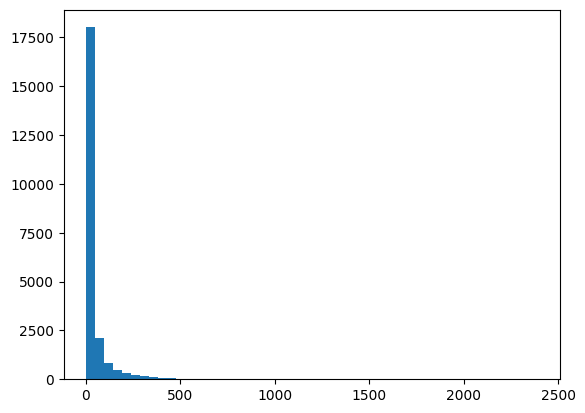

In [ ]:
train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

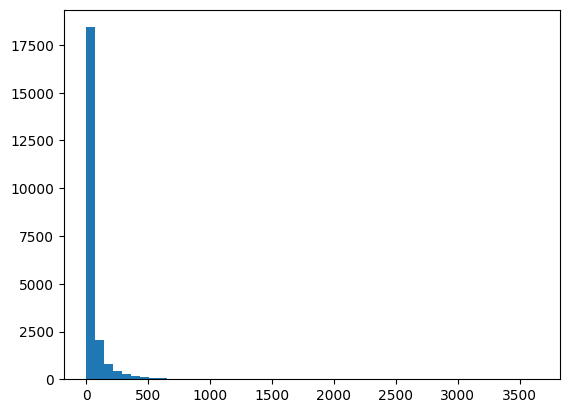

In [ ]:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

In [ ]:
max_input_len = 128
max_target_len = 128

In [ ]:
def tokenize_func(example):
  inputs = [x['en'] for x in example['translation']]
  targets = [x['fr'] for x in example['translation']]

  tokenized_inputs = tokenizer(inputs, max_length=max_input_len, truncation=True)

  with tokenizer.as_target_tokenizer():
    tokenized_targets = tokenizer(targets, max_length=max_target_len, truncation=True)

  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [ ]:
tokenized_datasets = split.map(tokenize_func, batched=True, remove_columns=split['train'].column_names)
tokenized_datasets

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 22500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7500
    })
})

## 3. Train Model

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
bleu_metric = load_metric('sacrebleu')
bert_metric = load_metric('bertscore')

def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {
      'bleu': bleu['score'],
      'bert_score': np.mean(bert_score['f1']),
  }

<ipython-input-17-0e6a0a1fc5bd>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('sacrebleu')


In [ ]:
training_args = Seq2SeqTrainingArguments('trainer_dir',
                                          per_device_train_batch_size=32,
                                          per_device_eval_batch_size=64,
                                          evaluation_strategy='no',
                                          save_strategy='epoch',
                                          num_train_epochs=3,
                                          learning_rate=2e-5,
                                          weight_decay=0.01,
                                          save_total_limit=3,
                                          predict_with_generate=True,
                                          fp16=True,
                                          )

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [ ]:
trainer.evaluate(max_length=max_target_len)

{'eval_loss': 1.726627230644226,
 'eval_bleu': 38.61663811851953,
 'eval_bert_score': 0.858096408355236,
 'eval_runtime': 592.4937,
 'eval_samples_per_second': 12.658,
 'eval_steps_per_second': 0.199}

In [ ]:
trainer.train()

Step,Training Loss
500,1.395600
1000,1.190000
1500,1.090400
2000,1.024600


TrainOutput(global_step=2112, training_loss=1.1670020854834355, metrics={'train_runtime': 426.966, 'train_samples_per_second': 158.092, 'train_steps_per_second': 4.947, 'total_flos': 1332971632852992.0, 'train_loss': 1.1670020854834355, 'epoch': 3.0})

## 4. Evaluate

In [ ]:
trainer.evaluate(max_length=max_target_len)

{'eval_loss': 1.1193413734436035,
 'eval_bleu': 47.98177422985642,
 'eval_bert_score': 0.8873261198759079,
 'eval_runtime': 568.059,
 'eval_samples_per_second': 13.203,
 'eval_steps_per_second': 0.208,
 'epoch': 3.0}

## 5. Predict

In [ ]:
trainer.save_model('my_saved_model')

In [ ]:
translator = pipeline(
    'translation',
    model='my_saved_model',
    device=0
)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
translator('I hope this course has helped you on your data science journey')

[{'translation_text': "J'espère que ce cours vous aidera dans votre parcours data science"}]